## Import packages

In [14]:
%matplotlib notebook

import pyFAI
import skimage.io as io
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Processing Parameters

In [15]:
det_cal = r'C:\Users\akiss\programming\xrd_testing\20190524_1600_ZnO_15keV.poni'

wd = r'C:\Users\akiss\programming\xrd_testing\\'
fn = 'scan2D_27830.tif'
fn_df = None
fn_ff = None

N_azi = 1000
N_rad = 500
out_units = 'q_nm^-1'  # use 'q_A^-1', 'q_nm^-1', '2th_deg', '2th_rad', 'r_mm'
output_ind_files = False
err_model = None  # use 'poisson', 'azimuthal', or None

## Load the detector calibration

In [16]:
ai = pyFAI.load(det_cal)
# print('Detector Calibration:\n', ai)

## Load the images

In [17]:
try:
    I = io.imread(wd + fn)
except Exception as e:
    print('Cannot open file. ', e)

try:
    if (fn_df is not None):
        I_df = io.imread(wd + fn_df)
    else:
        I_df = None
except Exception as e:
    print('Cannot open darkfield file. ', e)

try:
    if (fn_ff is not None):
        I_ff = io.imread(wd + fn_ff)
    else:
        I_ff = None
except Exception as e:
    print('Cannot open flatfield file. ', e)


## Make a single dark/flat field image

In [20]:
if (I_df is not None):
    I_df = np.array(I_df.data)
    if (I_df.ndim == 2):
        pass
    elif (I_df.ndim == 3):
        I_df = np.average(I_df, axis=0)
    else:
        print('I don\'t know what to do with the darkfield.')

if (I_ff is not None):
    I_ff = np.array(I_ff.data)
    if (I_ff.ndim == 2):
        pass
    elif (I_ff.ndim == 3):
        I_ff = np.average(I_ff, axis=0)
    else:
        print('I don\'t know what to do with the flatfield.')


## Fit the data in 1D

In [21]:
fitD = []
if (I.ndim == 2):
    I = np.array(I.data)
    I = I[np.newaxis, :]
elif (I.ndim == 3):
    I = np.array(I.data)
else:
    print('Image data does not have the right dimensions.')

num = I.shape[0]
for i in range(num):
    if (output_ind_files):
        tmp_fn = f'integrate1D_{i:04}.dat'
        res = ai.integrate1d(I[i, :, :],
                             N_azi,
                             unit=out_units,
                             dark=I_df,
                             flat=I_ff,
                             filename=f'integrate_{i:04}.dat',
                             error_model=err_model)
    else:
        res = ai.integrate1d(I[i, :, :],
                             N_azi,
                             dark=I_df,
                             flat=I_ff,
                             unit=out_units,
                             error_model=err_model)
    fitD.append(res)
del res

## Create a Pandas Dataframe of the data

In [6]:
dfD = pd.DataFrame()
dfD[out_units] = pd.Series(fitD[0][0])
for i in range(num):
    dfD[f'{i:04}'] = pd.Series(fitD[i][1])


## Fit the data in 2D

In [7]:
fitDD = []

for i in range(num):
    if (output_ind_files):
        res = ai.integrate2d(I[i, :, :],
                             N_rad,
                             N_azi,
                             unit=out_units,
                             dark=I_df,
                             flat=I_ff,
                             method='csr'
                             filename=f'integrate_{i:04}.dat')
    else:
        res = ai.integrate2d(I[i, :, :],
                             N_rad,
                             N_azi,
                             unit=out_units, 
                             dark=I_df,
                             flat=I_ff,
                             method='csr')
    fitDD.append(res)
del res

## Create a NumPy array of the variance

In [8]:
npDD = np.empty((num, N_azi))
for i in range(num):
    tmp = np.array(fitDD[i][0])
    npDD[i, :] = np.var(tmp, axis=1)
del tmp

## Add the variance data to the pandas dataframe and output

In [13]:
dfDD = pd.DataFrame()
dfDD[out_units] = pd.Series(fitD[0][0])
for i in range(num):
    dfDD[f'{i:04}_var'] = pd.Series(npDD[i, :])

df_all = dfD.join(dfDD.set_index(out_units), on=out_units)
df_all = df_all.reindex(sorted(df_all.columns), axis=1)

fn_out = wd + fn.split('.')[0] + '_processed'
df_all.to_csv(fn_out + '.csv')
df_all.to_pickle(fn_out + '.pkl')

## Plot the first image 2D data

<IPython.core.display.Javascript object>


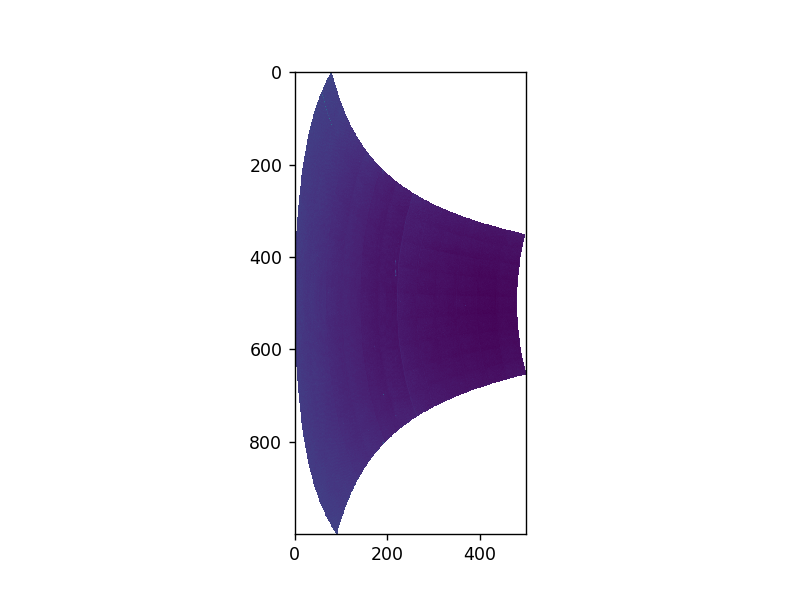

C:\ProgramData\Miniconda3\envs\pyfai\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
plt.figure()
img = np.array(fitDD[0][0])
plt.imshow(np.log10(img), cmap='viridis')


## Plot the data from the first image

<IPython.core.display.Javascript object>


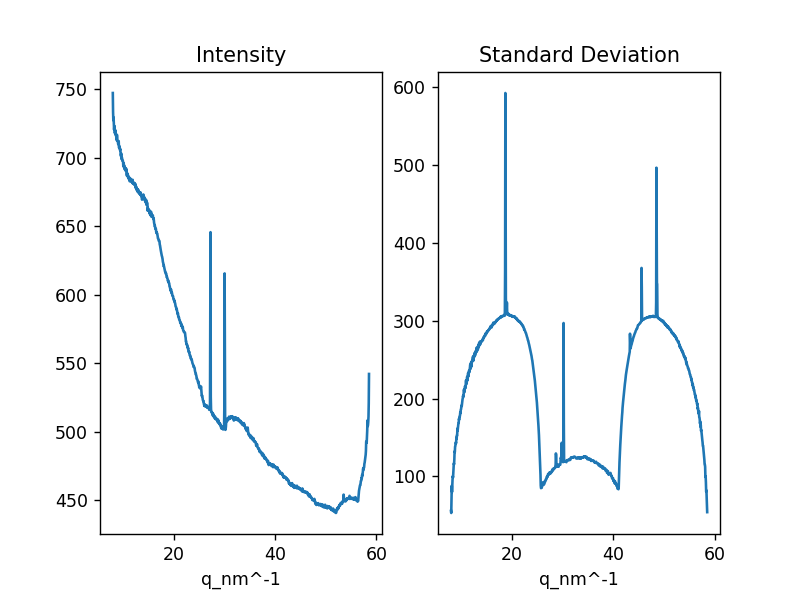

Text(0.5, 1.0, 'Standard Deviation')

In [11]:
plt.figure()
plt.subplot(121)
plt.plot(dfD[out_units].values, dfD['0000'].values, label='Intensity')
plt.xlabel(out_units)
plt.title('Intensity')
plt.subplot(122)
plt.plot(dfD[out_units].values, np.sqrt(dfDD['0000_var'].values), label='Standard Deviation')
plt.xlabel(out_units)
plt.title('Standard Deviation')
